In [1]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# MEASURES

In [2]:
import duckdb
QUERY = f"SELECT * FROM 'hf://datasets/clarkmaio/elia_predico/target.parquet'"
conn = duckdb.connect()
result = conn.execute(QUERY).fetchdf()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

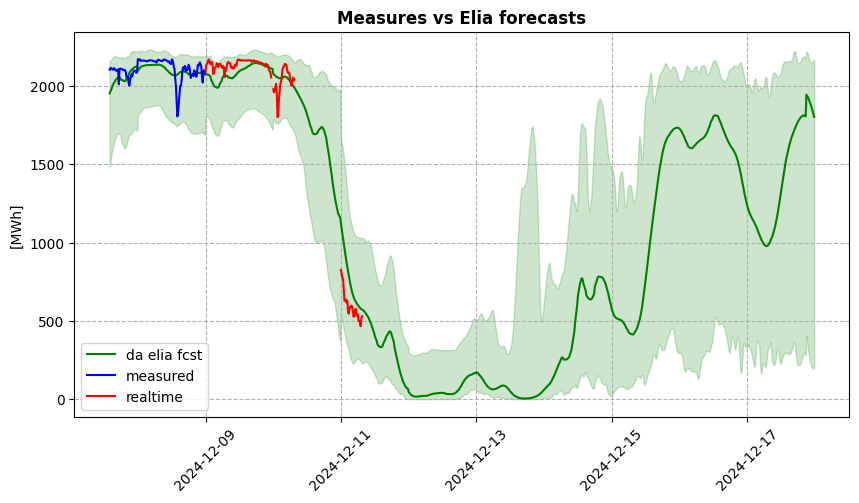

In [3]:
# Visualize target
df=result.set_index('datetime').tail(1000)

plt.figure(figsize=(10, 5))
plt.plot(df.index, df.dayahead11hforecast, label='da elia fcst', color='green')
plt.fill_between(df.index, y1=df.dayahead11hconfidence10, y2=df.dayahead11hconfidence90, color='green', alpha=.2)
plt.plot(df.index, df.measured, label='measured', color='blue')
plt.plot(df.index, df.realtime, label='realtime', color='red')
plt.grid(linestyle='--')
plt.ylabel('[MWh]')
plt.xticks(rotation=45)
plt.title('Measures vs Elia forecasts', fontweight='bold')
plt.legend()

In [4]:
# Coverage check
coverage_check = result.copy()
coverage_check['year'] = coverage_check.datetime.dt.year
coverage_check = coverage_check.dropna(subset='measured')
coverage_check['is_in_mostrecent'] = (coverage_check.measured <= coverage_check.mostrecentconfidence90) & (coverage_check.measured >= coverage_check.mostrecentconfidence10)
coverage_check['is_in_dayahead11'] = (coverage_check.measured <= coverage_check.dayahead11hconfidence90) & (coverage_check.measured >= coverage_check.dayahead11hconfidence10)
coverage_check['is_in_dayahead'] = (coverage_check.measured <= coverage_check.dayaheadconfidence90) & (coverage_check.measured >= coverage_check.dayaheadconfidence10)
coverage_check['is_in_weekahead'] = (coverage_check.measured <= coverage_check.weekaheadconfidence90) & (coverage_check.measured >= coverage_check.weekaheadconfidence10)
#coverage_check[['is_in_mostrecent', 'is_in_dayahead11', 'is_in_dayahead', 'is_in_weekahead']].sum() / coverage_check.shape[0]

/tmp/ipykernel_493950/1356382624.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(coverage_check_rolling.index[-1]+timedelta(days=2), coverage_check_rolling.mostrecent[-1], 'mostrecent', color='blue', va='top', ha='left', fontweight='bold')
/tmp/ipykernel_493950/1356382624.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(coverage_check_rolling.index[-1]+timedelta(days=2), coverage_check_rolling.dayahead[-1], 'dayahead', color='red', va='bottom', ha='left', fontweight='bold')
/tmp/ipykernel_493950/1356382624.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a

Text(2024-12-10 23:45:00+01:00, 0.795, 'theoretical coverage')

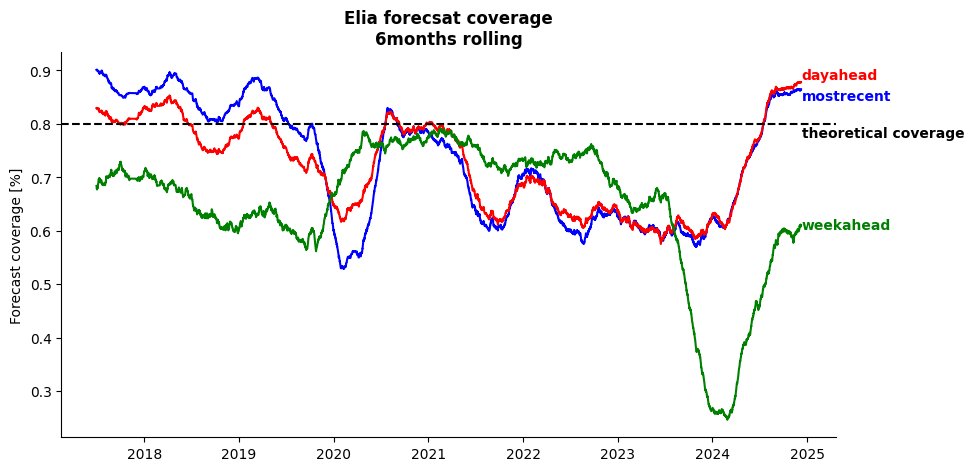

In [5]:
# Rolling coverage

MONTH = 6
WINDOW = 96*30*MONTH
coverage_check_rolling = coverage_check.set_index('datetime').rolling(WINDOW)[['is_in_mostrecent', 'is_in_dayahead', 'is_in_weekahead']].mean().dropna()
coverage_check_rolling.columns = [c.replace('is_in_', '') for c in coverage_check_rolling.columns]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(coverage_check_rolling.index, coverage_check_rolling.mostrecent, color='blue')
ax.plot(coverage_check_rolling.index, coverage_check_rolling.dayahead, color='red')
ax.plot(coverage_check_rolling.index, coverage_check_rolling.weekahead, color='green')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axhline(y=.8, linestyle='--', color='black', label='theoretical coverage')
ax.set_ylabel('Forecast coverage [%]')
ax.set_xlabel('')
ax.set_title(f'Elia forecsat coverage\n{MONTH}months rolling', fontweight='bold')

ax.text(coverage_check_rolling.index[-1]+timedelta(days=2), coverage_check_rolling.mostrecent[-1], 'mostrecent', color='blue', va='top', ha='left', fontweight='bold')
ax.text(coverage_check_rolling.index[-1]+timedelta(days=2), coverage_check_rolling.dayahead[-1], 'dayahead', color='red', va='bottom', ha='left', fontweight='bold')
ax.text(coverage_check_rolling.index[-1]+timedelta(days=2), coverage_check_rolling.weekahead[-1], 'weekahead', color='green', va='center', ha='left', fontweight='bold')
ax.text(coverage_check_rolling.index[-1]+timedelta(days=2), 0.795, 'theoretical coverage', color='black', va='top', ha='left', fontweight='bold')

# WEATHER

In [6]:
import duckdb
QUERY = f"SELECT valid_time-time as step, latitude, longitude, u10, v10, SQRT(u10^2 + v10^2) as speed10 FROM 'hf://datasets/clarkmaio/elia_predico/gfs_lastrun.parquet'"
conn = duckdb.connect()
result_step = conn.execute(QUERY).fetchdf()

STEP = 12
result_step['step'] = result_step['step'].dt.total_seconds() / 3600
result_step = result_step.query(f'step=={STEP}')

In [7]:
QUERY = f"SELECT valid_time, valid_time-time as step, time, latitude, longitude, u10, v10, SQRT(u10^2 + v10^2) as speed10, gust, cape FROM 'hf://datasets/clarkmaio/elia_predico/gfs_lastrun.parquet'"
conn = duckdb.connect()
result_total = conn.execute(QUERY).fetchdf()
result_total['step'] = result_total['step'].dt.total_seconds() / 3600
FRUN = result_total.time.max()
result_total.drop('time', axis=1, inplace=True)
result_total = result_total.groupby('valid_time').mean().resample('h').interpolate('cubic')

/tmp/ipykernel_493950/4017002480.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax_speed10.text(x=result_total.step.max(), y=result_total.speed10[-1], s='speed10', color='blue', va='bottom', ha='left', fontweight='bold')
/tmp/ipykernel_493950/4017002480.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax_gust.text(x=result_total.step.max(), y=result_total.gust[-1], s='gust', color='green', va='bottom', ha='left', fontweight='bold')
/tmp/ipykernel_493950/4017002480.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as la

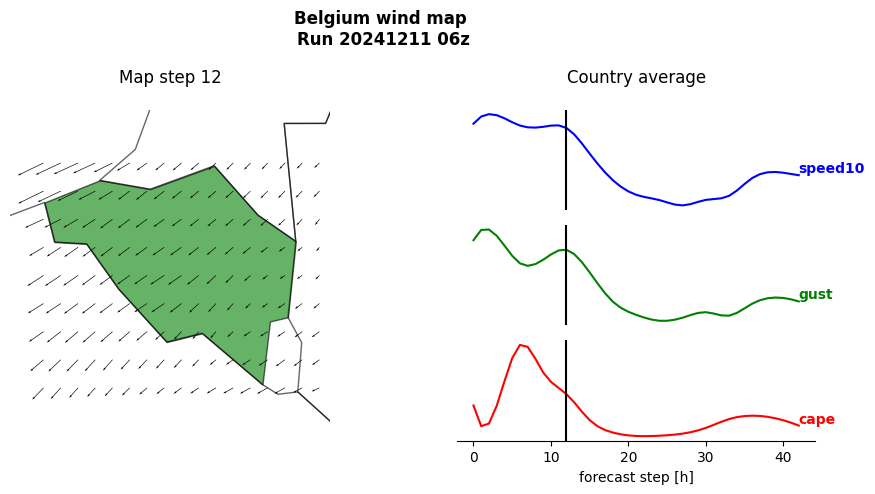

In [8]:
import geopandas as gpd

fig = plt.figure(figsize=(10, 5))
fig.suptitle(f'Belgium wind map \nRun {FRUN.strftime("%Y%m%d %Hz")}', fontweight='bold')

ax_map = plt.subplot2grid(shape=(3, 5), loc=(0,0), rowspan=3, colspan=3, fig=fig)
ax_speed10 = plt.subplot2grid(shape=(3, 5), loc=(0,3), colspan=2)
ax_gust = plt.subplot2grid(shape=(3, 5), loc=(1,3), colspan=2)
ax_cape = plt.subplot2grid(shape=(3, 5), loc=(2,3), colspan=2)

# --------------------- PLOT MAP
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
gdf = gpd.read_file(url)

for c in ['Germany', 'Belgium', 'France', 'Netherlands']:
    color='none'
    if c == 'Belgium':
        color='green'
    gdf[gdf["ADMIN"] == c].plot(ax=ax_map, color=color, edgecolor='black', linewidth=1, alpha=.6)


ax_map.quiver(
    result_step["longitude"], result_step["latitude"], result_step["u10"], result_step["v10"],
    scale=90, color="black",
    width=.002

)

minx, miny, maxx, maxy = gdf[gdf["ADMIN"] == 'Belgium'].total_bounds
buffer = 0.5  # Per aggiungere un margine ai confini
ax_map.set_xlim(minx - buffer, maxx + buffer)
ax_map.set_ylim(miny - buffer, maxy + buffer)
ax_map.axis('off')


ax_map.set_title(f'Map step {STEP}', pad=20)


# ------------------------------ TIMESERIES
ax_speed10.plot(result_total.step, result_total.speed10, color='blue')
ax_gust.plot(result_total.step, result_total.gust, color='green')
ax_cape.plot(result_total.step, result_total.cape, color='red')


# Legend
ax_speed10.text(x=result_total.step.max(), y=result_total.speed10[-1], s='speed10', color='blue', va='bottom', ha='left', fontweight='bold')
ax_gust.text(x=result_total.step.max(), y=result_total.gust[-1], s='gust', color='green', va='bottom', ha='left', fontweight='bold')
ax_cape.text(x=result_total.step.max(), y=result_total.cape[-1], s='cape', color='red', va='bottom', ha='left', fontweight='bold')



# Minimal axis and  ticks
ax_speed10.set_xticklabels('')
ax_gust.set_xticklabels('')

ax_speed10.axis('off')
ax_gust.axis('off')

ax_cape.spines['top'].set_visible(False)
ax_cape.spines['left'].set_visible(False)
ax_cape.spines['right'].set_visible(False)
ax_cape.set_yticks([])

ax_speed10.axvline(x=STEP, color='black')
ax_gust.axvline(x=STEP, color='black')
ax_cape.axvline(x=STEP, color='black')
ax_cape.set_xlabel('forecast step [h]')

ax_speed10.set_title('Country average', pad=20)

plt.tight_layout()


